In [16]:
import numpy as np
import random

In [17]:
np.random.seed(10)
n_all, train_percent = 60, 0.85
# параметры распределения X
x_min, x_max = 5, 105
# генерируем X
x = np.random.uniform(x_min, x_max, n_all)
# генерируем случайный шум
mu, sigma = 0, 1
res = np.random.normal(mu, sigma, n_all)
# отбираем наблюдения в обучающую выборку
in_train = np.random.choice(np.arange(n_all),
 int(n_all*train_percent), replace=False)
# истинная функция взаимосвязи
def y_func (x) :
 return(6+3.5*np.cos((x-30)/12))

# для графика истинной взаимосвязи
x_line = np.linspace(x_min, x_max, n_all)
y_line = y_func(x_line)
# фактические значения y (с шумом)
y = y_func(x) + res
# создаём векторы с данными для построения графиков
# наблюдения на обучающей выборке
x_train = x[in_train]
y_train = y[in_train]
# наблюдения на тестовой выборке
x_test = np.delete(x, in_train)
y_test = np.delete(y, in_train)

In [18]:

 # загрузка пакетов
import matplotlib.pyplot as plt

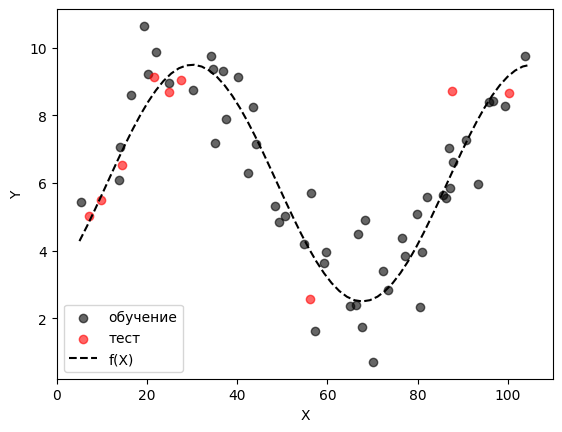

In [19]:
plt.scatter(x_train, y_train, c='black', label='обучение', alpha=0.6)
#  тестовая выборка
plt.scatter(x_test, y_test, c='red', label='тест', alpha=0.6)
#  истинная функция взаимосвязи
plt.plot(x_line, y_line, c='black', linestyle='dashed', label='f(X)')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
#  легенда
plt.legend()
plt.show()

In [20]:
from pandas import DataFrame
import rpy2.robjects as robjects

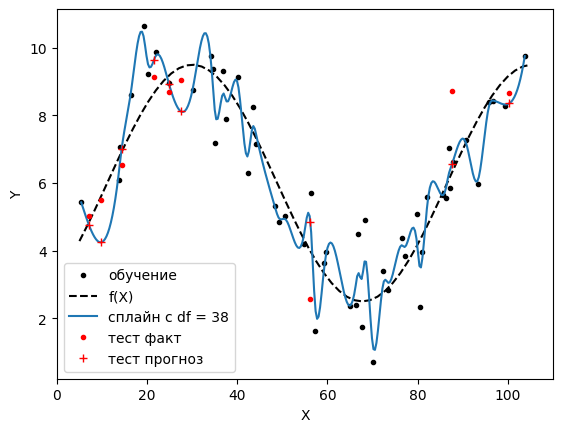

In [21]:
 # модель натурального сплайна с заданным количеством узлов (df)
my_df = 38
# сохраняем индексы отсортированного по возрастанию x из обучающей выборк

x_sorted_index = sorted(range(len(x_train)), key=lambda k: x_train[k])
# равноотстоящие координаты по X для прорисовки сглаженной кривой
x_train_lin = np.linspace(min(x_train), max(x_train), num=300,
endpoint=True)
# создаём из данных объекты, понятные R
r_x = robjects.FloatVector(x_train)
r_y = robjects.FloatVector(y_train)
# импортируем нужную функцию из R
r_smooth_spline = robjects.r['smooth.spline']
# строим сглаживающий сплайн
fit = r_smooth_spline(x=r_x, y=r_y, df=my_df)
# делаем прогнозы
y_hat_train = np.array(robjects.r['predict'](fit,
robjects.FloatVector(x_train)).rx2('y'))
y_hat_test = np.array(robjects.r['predict'](fit,
robjects.FloatVector(x_test)).rx2('y'))
y_lin_plot = np.array(robjects.r['predict'](fit,
robjects.FloatVector(x_train_lin)).rx2('y'))
# строим график
plt.plot(x_train, y_train, color='black', ls='', marker='.',
label='обучение')
plt.plot(x_line, y_line, color='black', ls='dashed', marker='',
label='f(X)')
plt.plot(x_train_lin, y_lin_plot, marker='',
label='сплайн с df = %s' % my_df)
plt.plot(x_test, y_test, color='red', ls='', marker='.',
label='тест факт')
plt.plot(x_test, y_hat_test, color='red', ls='', marker='+',
label='тест прогноз')
#  подписи осей
plt.xlabel('X')
plt.ylabel('Y')
# легенда
plt.legend(loc='best')
# считаем MSE
MSE_fit = [sum((y_train - y_hat_train)**2) / len(y_train),
sum((y_test - y_hat_test)**2) / len(y_test)]


In [22]:
# выводим MSE с округлением
np.around(MSE_fit, 2)

array([0.27, 1.45])

In [23]:
 #  Теперь строим модели с df от 2 до 40 #################################
 ###
# максимальное число степеней свободы для модели сплайна
max_df = 40
# фрейм данных для сохранения MSE на обучающей и на тестовой
#  при разных степенях свободы
MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
index=list(range(2, max_df+1)))
# заполняем фрейм
for i_df in range(2, max_df+1) :
# обучаем модель
  fit = r_smooth_spline(x=r_x, y=r_y, df=i_df)
# прогноз на обучающей выборке
# прогноз на тестовой выборке
# считаем MSE
  y_train_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_train)).rx2('y'))
  y_test_hat = np.array(robjects.r['predict'](fit,
    robjects.FloatVector(x_test)).rx2('y'))
  MSE_all_dfs.loc[i_df, 'MSE_train'] =  sum((y_train - y_train_hat)**2) / len(y_train_hat)
  MSE_all_dfs.loc[i_df, 'MSE_test'] =  sum((y_test - y_test_hat)**2) / len(y_test_hat)

In [30]:
 # фильтруем таблицу по минимальной MSE на тестовой выборке
MSE_all_dfs[MSE_all_dfs['MSE_test'] == min(MSE_all_dfs['MSE_test'])]

,MSE_train,MSE_test
24,0.651214,0.895104


In [33]:
optimal_df = MSE_all_dfs['MSE_test'].idxmin()
print(optimal_df)

24


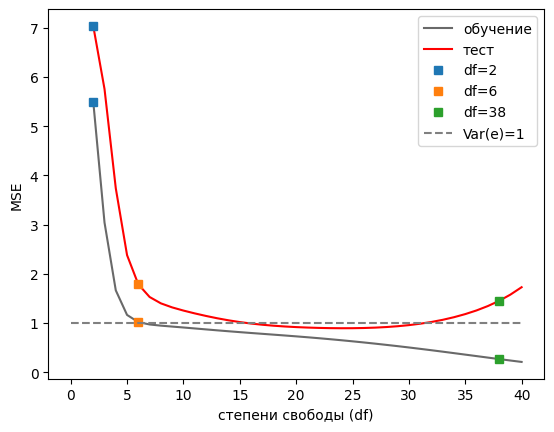

In [25]:
 # график изменения MSE с увеличением df
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_train'], color='dimgrey',
marker='', label='обучение')
plt.plot(MSE_all_dfs.index, MSE_all_dfs['MSE_test'], color='red',
marker='', label='тест')
plt.plot([2, 2], [MSE_all_dfs.iloc[0]['MSE_train'],
MSE_all_dfs.iloc[0]['MSE_test']],
ls='', marker='s', label='df=2')
plt.plot([6, 6], [MSE_all_dfs.iloc[4]['MSE_train'],
MSE_all_dfs.iloc[4]['MSE_test']],
ls='', marker='s', label='df=6')
plt.plot([38, 38], [MSE_all_dfs.iloc[36]['MSE_train'],
MSE_all_dfs.iloc[36]['MSE_test']],
ls='', marker='s', label='df=38')
plt.hlines(1, 0, 40, linestyles='dashed', color='grey', label='Var(e)=1')
#  подписи осей
# легенда
plt.xlabel('степени свободы (df)')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

In [35]:
import warnings
warnings.filterwarnings('ignore')

sample_sizes = [150, 100, 50]
mse_results = {}

for n_size in sample_sizes:
    MSE_df, _, _, _, _ = generate_data_and_calculate_mse(n_size, 0.85, 10)

    optimal_df = MSE_df['MSE_test'].idxmin()
    mse_train_optimal = MSE_df.loc[optimal_df, 'MSE_train']
    mse_test_optimal = MSE_df.loc[optimal_df, 'MSE_test']
    mse_train_complex = MSE_df.loc[40, 'MSE_train']
    mse_test_complex = MSE_df.loc[40, 'MSE_test']

    mse_results[n_size] = {
        'mse_train_optimal': mse_train_optimal,
        'mse_test_optimal': mse_test_optimal,
        'mse_train_complex': mse_train_complex,
        'mse_test_complex': mse_test_complex
    }

    print(f"n_all = {n_size}:")
    print(f"  MSE_train (оптим.): {mse_train_optimal:.4f}")
    print(f"  MSE_test (оптим.): {mse_test_optimal:.4f}")
    print(f"  MSE_train (df=40): {mse_train_complex:.4f}")
    print(f"  MSE_test (df=40): {mse_test_complex:.4f}")
    print()

print("При уменьшении объема выборки:")
print(f"Минимальная MSE_test: {mse_results[150]['mse_test_optimal']:.4f} → {mse_results[100]['mse_test_optimal']:.4f} → {mse_results[50]['mse_test_optimal']:.4f}")
print(f"Переобучение (разница MSE): {mse_results[150]['mse_test_complex'] - mse_results[150]['mse_train_complex']:.4f} → {mse_results[100]['mse_test_complex'] - mse_results[100]['mse_train_complex']:.4f} → {mse_results[50]['mse_test_complex'] - mse_results[50]['mse_train_complex']:.4f}")

n_all = 150:
  MSE_train (оптим.): 0.9018
  MSE_test (оптим.): 0.9085
  MSE_train (df=40): 0.5348
  MSE_test (df=40): 1.6024

n_all = 100:
  MSE_train (оптим.): 0.9383
  MSE_test (оптим.): 1.3006
  MSE_train (df=40): 0.3906
  MSE_test (df=40): 2.0940

n_all = 50:
  MSE_train (оптим.): 0.9482
  MSE_test (оптим.): 0.2906
  MSE_train (df=40): 0.0070
  MSE_test (df=40): 5.5297

При уменьшении объема выборки:
Минимальная MSE_test: 0.9085 → 1.3006 → 0.2906
Переобучение (разница MSE): 1.0676 → 1.7034 → 5.5228
